In [1]:
import torch
from torch.nn.functional import relu
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [2]:
aug = MNISTAug()
dm = DataManager()
dm.load_test()

In [3]:
aug.min_objects = 1
aug.max_objects = 1

In [4]:
x_train, y_train = aug.get_augmented(dm.x_test, dm.y_test, 1000)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 2)

cannot convert float infinity to integer


/Users/akhildevarashetti/code/ml_gallery/ml_py/venv/lib/python3.8/site-packages/skimage/transform/_warps.py:115: RuntimeWarning: divide by zero encountered in true_divide
  factors = (np.asarray(input_shape, dtype=float) /


In [5]:
x_train = torch.tensor(x_train.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')
x_test = torch.tensor(x_test.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

/Users/akhildevarashetti/code/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:354: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[{'id': 0,
  'class': 7,
  'class_one_hot': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
  'x1': 88,
  'y1': 2,
  'x2': 99,
  'y2': 13,
  'cx': 93.5,
  'cy': 7.5,
  'height': 11,
  'width': 11,
  'type': 'number'}]

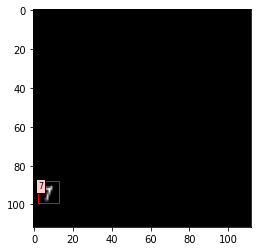

In [6]:
DataManager.plot_num(x_train[1].reshape((112, 112)), y_train[1])
y_train[1]

In [7]:
anchor_cx = 56
anchor_cy = 56
anchor_w = 28

In [8]:
def units_to_diff(y):
    y_d = []
    for i in range(len(y)):
        cx_d = (y[i][0]['cx'] - anchor_cx) / 112
        cy_d = (y[i][0]['cy'] - anchor_cy) / 112
        w_d = (y[i][0]['width'] - anchor_w) / 112
        y_d.append((cx_d, cy_d, w_d))
    return torch.tensor(y_d)

def diff_to_units(y):
    y_units = []
    for i in range(len(y)):
        cx_d = y[i][0] * 112 + anchor_cx
        cy_d = y[i][1] * 112 + anchor_cy
        wd = y[i][2] * 112 + anchor_w
        y_units.append((cx_d, cy_d, wd))
    return torch.tensor(y_units)

In [9]:
print(y_test)
y_d_test = units_to_diff(y_test)
print(y_d_test)
y_d_unwrapped = diff_to_units(y_d_test)
print(y_d_unwrapped)

[[{'id': 0, 'class': 0, 'class_one_hot': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'x1': 11, 'y1': 64, 'x2': 31, 'y2': 84, 'cx': 21.0, 'cy': 74.0, 'height': 20, 'width': 20, 'type': 'number'}], [{'id': 0, 'class': 7, 'class_one_hot': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]), 'x1': 29, 'y1': 24, 'x2': 66, 'y2': 61, 'cx': 47.5, 'cy': 42.5, 'height': 37, 'width': 37, 'type': 'number'}]]
tensor([[-0.3125,  0.1607, -0.0714],
        [-0.0759, -0.1205,  0.0804]])
tensor([[21.0000, 74.0000, 20.0000],
        [47.5000, 42.5000, 37.0000]])


In [10]:
y_d = units_to_diff(y_train)
y_d_test = units_to_diff(y_test)

In [11]:
class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)  # 112x112
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 56x56
        self.conv3 = torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 28x28
        self.conv4 = torch.nn.Conv2d(128, 256, 3, stride=2, padding=1)  # 14x14
        self.conv5 = torch.nn.Conv2d(256, 512, 3, stride=2, padding=1)  # 7x7
        self.linear1 = torch.nn.Linear(25088, 4096)
        self.linear2 = torch.nn.Linear(4096, 512)
        self.linear3 = torch.nn.Linear(512, 3)

    def forward(self, x):
        x = relu(self.conv1(x))  # 112
        x = relu(self.conv2(x))  # 56
        x = relu(self.conv3(x))  # 28
        x = relu(self.conv4(x))  # 14
        x = relu(self.conv5(x))  # 7
        x = torch.flatten(x, 1)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        x = torch.nn.functional.tanh(self.linear3(x))
        return x


model = DetectorV1()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
epochs = 4
batch_size = 100

for epoch in range(epochs):

    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_d[start_index:end_index]
        
        optimizer.zero_grad()

        y_hat = model(x_batch)

        loss = sum(sum((y_batch - y_hat)**2))
        
        loss.backward()
        optimizer.step()

        loss = float(loss.detach())
        print(f'{epoch=}, batch={i}, loss={loss}')
        writer.add_scalar("Loss/train", loss, epoch * batch_size + i / batch_size)

writer.flush()
writer.close()

/Users/akhildevarashetti/code/ml_gallery/ml_py/venv/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch=0, batch=0, loss=12.237242698669434
epoch=0, batch=100, loss=103.9077377319336
epoch=0, batch=200, loss=15.443633079528809
epoch=0, batch=300, loss=10.746805191040039
epoch=0, batch=400, loss=10.648369789123535
epoch=0, batch=500, loss=11.259020805358887
epoch=0, batch=600, loss=10.498801231384277
epoch=0, batch=700, loss=12.139537811279297
epoch=0, batch=800, loss=11.079343795776367
epoch=0, batch=900, loss=9.9447603225708
epoch=1, batch=0, loss=11.454277992248535
epoch=1, batch=100, loss=9.571359634399414
epoch=1, batch=200, loss=9.529488563537598
epoch=1, batch=300, loss=8.44008731842041
epoch=1, batch=400, loss=7.336843967437744
epoch=1, batch=500, loss=6.1868085861206055
epoch=1, batch=600, loss=9.565130233764648
epoch=1, batch=700, loss=6.331085205078125
epoch=1, batch=800, loss=6.826923370361328
epoch=1, batch=900, loss=6.095118999481201
epoch=2, batch=0, loss=7.45489501953125
epoch=2, batch=100, loss=4.39067268371582
epoch=2, batch=200, loss=4.70501708984375
epoch=2, batc

y_pred=tensor([[-0.3365,  0.1562, -0.0060],
        [-0.0862, -0.1307,  0.0563]])
y_d_test=tensor([[-0.3125,  0.1607, -0.0714],
        [-0.0759, -0.1205,  0.0804]])
[{'x1': 4.649696350097656, 'y1': 59.833065032958984, 'x2': 31.975265502929688, 'y2': 87.15863037109375}]
[{'x1': 29.19240951538086, 'y1': 24.206371307373047, 'x2': 63.494808197021484, 'y2': 58.50876998901367}]


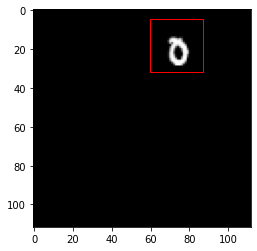

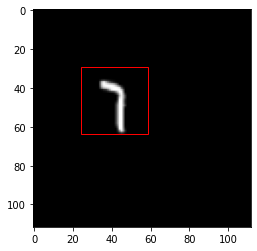

In [13]:
with torch.no_grad():
    y_pred = model(x_test)
    
    print(f'{y_pred=}\n{y_d_test=}')
    
    y_pred = diff_to_units(y_pred)
    for i in range(len(y_pred)):

        cx_pred, cy_pred, w_pred = y_pred[i]
        pred_boxes = [{
            'x1': float(cx_pred - w_pred / 2),
            'y1': float(cy_pred - w_pred / 2),
            'x2': float(cx_pred + w_pred / 2),
            'y2': float(cy_pred + w_pred / 2)
        }]

        # pred_boxes.extend(list(y_test[i]))
        print(f'{pred_boxes}')

        DataManager.plot_num(x_test[i].reshape((112, 112)), pred_boxes)
